#### Libraries Imported and Setup

In [1]:
import torch
from torch import nn
from torch import functional as F
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('GPU: ', torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print('No GPU available')

GPU:  NVIDIA GeForce RTX 3090


#### Model Architecture

##### Vision Transformer Model

In [3]:
class Attention(nn.Module):
    '''
    Attention Module used to perform self-attention operation allowing the model to attend
    information from different representation subspaces on an input sequence of embeddings.
    The sequence of operations is as follows :-

    Input -> Query, Key, Value -> ReshapeHeads -> Query.TransposedKey -> Softmax -> Dropout
    -> AttentionScores.Value -> ReshapeHeadsBack -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        _reshape_heads(inp) :- 
        Changes the input sequence embeddings to reduced dimension according to the number
        of attention heads to parallelize attention operation
        (batch_size, seq_len, embed_dim) -> (batch_size * heads, seq_len, reduced_dim)

        _reshape_heads_back(inp) :-
        Changes the reduced dimension due to parallel attention heads back to the original
        embedding size
        (batch_size * heads, seq_len, reduced_dim) -> (batch_size, seq_len, embed_dim)

        forward(inp) :-
        Performs the self-attention operation on the input sequence embedding.
        Returns the output of self-attention as well as atttention scores
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim), (batch_size * heads, seq_len, seq_len)

    Examples:
        >>> attention = Attention(embed_dim, heads, activation, dropout)
        >>> out, weights = attention(inp)
    '''
    def __init__(self, embed_dim, heads=8, activation=None, dropout=0.1):
        super(Attention, self).__init__()
        self.heads = heads
        self.embed_dim = embed_dim
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        # self.value = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax(dim=-1)
        if activation == 'relu':
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        query = self.activation(self.query(inp))
        key   = self.activation(self.key(inp))
        # value = self.activation(self.value(inp))

        # output of _reshape_heads(): (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        query = self._reshape_heads(query)
        key   = self._reshape_heads(key)
        # value = self._reshape_heads(value)

        # attention_scores: (batch_size * heads, seq_len, seq_len) | Softmaxed along the last dimension
        attention_scores = self.softmax(torch.matmul(query, key.transpose(1, 2)))

        # out: (batch_size * heads, seq_len, reduced_dim)
        out = torch.matmul(self.dropout(attention_scores), key)
        
        # output of _reshape_heads_back(): (batch_size, seq_len, embed_size)
        out = self._reshape_heads_back(out)

        return out, attention_scores

    def _reshape_heads(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()

        reduced_dim = self.embed_dim // self.heads
        assert reduced_dim * self.heads == self.embed_dim
        out = inp.reshape(batch_size, seq_len, self.heads, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(-1, seq_len, reduced_dim)

        # out: (batch_size * heads, seq_len, reduced_dim)
        return out

    def _reshape_heads_back(self, inp):
        # inp: (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        batch_size_mul_heads, seq_len, reduced_dim = inp.size()
        batch_size = batch_size_mul_heads // self.heads

        out = inp.reshape(batch_size, self.heads, seq_len, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(batch_size, seq_len, self.embed_dim)

        # out: (batch_size, seq_len, embed_dim)
        return out

In [4]:
# Check if Dropout should be used after second Linear Layer
class FeedForward(nn.Module):
    '''
    FeedForward Network with two sequential linear layers with GELU activation function
    ,applied to the output of self attention operation. The sequence of operations is as
    follows :-
    
    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> FF = FeedForward(8, 1)
        >>> out = FF(inp)
    '''
    def __init__(self, embed_dim, forward_expansion=1, dropout=0.1):
        super(FeedForward, self).__init__()
        self.embed_dim = embed_dim
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_expansion)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_expansion, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.dropout(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, seq_len, embed_dim)
        return out 

In [5]:
class TransformerBlock(nn.Module):
    '''
    Transformer Block combines both the attention module and the feed forward module with layer
    normalization, dropout and residual connections. The sequence of operations is as follows :-
    
    Input -> LayerNorm1 -> Attention -> Residual -> LayerNorm2 -> FeedForward -> Output
      |                                   |  |                                      |
      |-------------Addition--------------|  |---------------Addition---------------|

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> TB = TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout)
        >>> out = TB(inp)
    '''
    def __init__(self, embed_dim, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = Attention(embed_dim, heads, activation, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = FeedForward(embed_dim, forward_expansion, dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        res = inp
        out = self.norm1(inp)
        out, _ = self.attention(out)
        out = out + res
        
        res = out
        out = self.norm2(out)
        out = self.feed_forward(out)
        out = out + res

        # out: (batch_size, seq_len, embed_dim)
        return out

In [6]:
class Transformer(nn.Module):
    '''
    Transformer combines multiple layers of Transformer Blocks in a sequential manner. The sequence
    of the operations is as follows -

    Input -> TB1 -> TB2 -> .......... -> TBn (n being the number of layers) -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        layers: Number of Transformer Blocks in the Transformer
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        >>> out = transformer(inp)
    '''
    def __init__(self, embed_dim, layers, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.trans_blocks = nn.ModuleList(
            [TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout) for i in range(layers)]
        )

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)

        out = inp
        for block in self.trans_blocks:
            out = block(out)

        # out: (batch_size, seq_len, embed_dim)
        return out

In [7]:
# Not Exactly Same as Paper
class ClassificationHead(nn.Module):
    '''
    Classification Head attached to the first sequence token which is used as the arbitrary 
    classification token and used to optimize the transformer model by applying Cross-Entropy 
    loss. The sequence of operations is as follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classification classes in the dataset
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, embed_dim) -> (batch_size, classes)

    Examples:
        >>> CH = ClassificationHead(embed_dim, classes, dropout)
        >>> out = CH(inp)
    '''
    def __init__(self, embed_dim, classes, dropout=0.1):
        super(ClassificationHead, self).__init__()
        self.embed_dim = embed_dim
        self.classes = classes
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim // 2, classes)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, inp):
        # inp: (batch_size, embed_dim)
        batch_size, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.softmax(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, classes) 
        return out

In [8]:
class VisionTransformer(nn.Module):
    '''
    Vision Transformer is the complete end to end model architecture which combines all the above modules
    in a sequential manner. The sequence of the operations is as follows -

    Input -> CreatePatches -> ClassToken, PatchToEmbed , PositionEmbed -> Transformer -> ClassificationHead -> Output
                                   |            | |                |
                                   |---Concat---| |----Addition----|
    
    Args:
        patch_size: Length of square patch size 
        max_len: Max length of learnable positional embedding
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classes in the dataset
        layers: Number of Transformer Blocks in the Transformer
        channels: Number of channels in the input (Default=3)
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        It outputs the classification output as well as the sequence output of the transformer
        (batch_size, channels, width, height) -> (batch_size, classes), (batch_size, seq_len+1, embed_dim)
    
    Examples:
        >>> ViT = VisionTransformer(atch_size, max_len, embed_dim, classes, layers, channels, heads, activation, forward_expansion, dropout)
        >>> class_out, hidden_seq = ViT(inp)
    '''
    def __init__(self, patch_size, max_len, embed_dim, classes, layers, channels=3, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.name = 'VisionTransformer'
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.channels = channels
        self.patch_to_embed = nn.Linear(patch_size * patch_size * channels, embed_dim)
        self.position_embed = nn.Parameter(torch.randn((max_len, embed_dim)))
        self.transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        self.classification_head = ClassificationHead(embed_dim, classes)
        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, inp):
        # inp: (batch_size, channels, width, height)
        batch_size, channels, width, height = inp.size()
        assert channels == self.channels

        out = inp.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size).contiguous()
        out = out.view(batch_size, channels, -1, self.patch_size, self.patch_size)
        out = out.permute(0, 2, 3, 4, 1)
        # out: (batch_size, seq_len, patch_size, patch_size, channels) | seq_len would be (width*height)/(patch_size**2)
        batch_size, seq_len, patch_size, _, channels = out.size()
        
        out = out.reshape(batch_size, seq_len, -1)
        out = self.patch_to_embed(out)
        # out: (batch_size, seq_len, embed_dim)

        class_token = self.class_token.expand(batch_size, -1, -1)
        out = torch.cat([class_token, out], dim=1)
        # out: (batch_size, seq_len+1, embed_dim)

        position_embed = self.position_embed[:seq_len+1]
        position_embed = position_embed.unsqueeze(0).expand(batch_size, seq_len+1, self.embed_dim)
        out = out + position_embed
        # out: (batch_size, seq_len+1, embed_dim) | Added Positional Embeddings

        out = self.transformer(out)
        # out: (batch_size, seq_len+1, embed_dim) 
        class_token = out[:, 0]
        # class_token: (batch_size, embed_dim)

        class_out = self.classification_head(class_token)
        # class_out: (batch_size, classes)
        
        return class_out, out

In [9]:
import torch
import torch.nn as nn
from torchvision.models import resnet34

class ResNetFeatures(nn.Module):
    '''
    ResNetFeatures outputs the lower level features from pretrained ResNet34 till the intial 5 layers 
    (conv1, bn1, relu, maxpool, layer1(3 conv layers)) to be used in the hybrid architecture to be 
    able to kickstart the learining faster. The sequence of operations is as follows :-

    Input -> conv1 -> bn1 -> relu -> maxpool -> layer1 -> Output

    Args:
        No arguments required
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, 3, 224, 224) -> (batch_size, 64, 56, 56)
    
    Examples:
        >>> resnet_features = ResNetFeatures()
        >>> out = resnet_features(inp)
    '''
    def __init__(self):
        super(ResNetFeatures, self).__init__()
        layers = list(resnet34(pretrained=True).children())[:5] #all layer expect last layer
        self.feature_extractor = nn.Sequential(*layers)
        
    def forward(self, inp):
        # inp: (batch_size, 3, 224, 224)

        out = self.feature_extractor(inp)

        # out: (batch_size, 64, 56, 56)
        return out

##### ResNet Models

In [10]:
class ResidualBlockSmall(nn.Module):
    '''
    ResidualBlockSmall implements the smaller block of the Residual Networks. It optionally also downsamples
    the input according to the stride to match the output while adding the residual. The sequence of operations
    is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> Conv2 -> BNorm2 -> ReLU -> Output
      |                                                              |
      |-----------------Residual_Downsample (Optional)---------------|

    Args:
        input_channels: Number of input channels
        out_channels: Number of output channels
        residual_downsample: Residual Downsample dependent on if either height, width or channels change
        stride: Stride value for the convolutional layers (Default=1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, out_channels, height, width)
    
    Examples:
        >>> RBS = ResidualBlockSmall(input_channels, out_channels, residual_downsample, stride)
        >>> out = RBS(inp)
    '''
    def __init__(self, input_channels, out_channels, residual_downsample=None, stride=1):
        super(ResidualBlockSmall, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        self.residual_downsample = residual_downsample
    
    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        res = inp
        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.activation(self.bnorm2(self.conv2(out)))
        
        if self.residual_downsample is not None:
            res = self.residual_downsample(res)

        out = self.activation(out + res)

        # out: (batch_size, out_channels, height, width) | height, width depending on stride
        return out

In [11]:
class ResNetSmall(nn.Module):
    '''
    ResNetSmall consists of layers of the smaller residual block defined above (ResidualBlockSmall).
    The layers are the residual blocks. The sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> MaxPool -> Layer1 -> Layer2 -> Layer3 -> Layer4 -> AvgPool -> FC

    Args:
        layers: A four value array containing number of conv layers in each residual block
        input_channels: number of input channels
        classes: Number of classes in the dataset
    
    Methods:
        _layer(num_layers (Number of conv layers)
               ,input_channels (Number of input channels)
               ,output_channels (Number of output channels)
               ,stride (Stride value for conv layer)) :-
        Returns the sequential wrapper with all the layers in the residual block constructed according
        to the parameters.

        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, classes)

    Examples:
        >>> resnet = ResNetSmall(layers, input_channels, classes)
        >>> out = resnet(inp)
    '''
    def __init__(self, layers, input_channels, classes):
        super(ResNetSmall, self).__init__()
        self.name = 'ResNet'
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._layer(layers[0], input_channels=64, output_channels=64, stride=1)
        self.layer2 = self._layer(layers[1], input_channels=64, output_channels=128, stride=2)
        self.layer3 = self._layer(layers[2], input_channels=128, output_channels=256, stride=2)
        self.layer4 = self._layer(layers[3], input_channels=256, output_channels=512, stride=2)

        self.avppool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, classes)

    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avppool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        # out: (batch_size, classes)
        return out

    def _layer(self, num_layers, input_channels, output_channels, stride):
        residual_downsample = None
        layers = []

        if stride != 1:
            residual_downsample = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(output_channels * 4)
            )
        
        layers.append(ResidualBlockSmall(input_channels, output_channels, residual_downsample, stride))

        for i in range(num_layers - 1):
            layers.append(ResidualBlockSmall(output_channels, output_channels))

        return nn.Sequential(*layers)

In [12]:
class ResidualBlockLarge(nn.Module):
    '''
    ResidualBlockLarge implements the larger block of the Residual Networks. It optionally also downsamples
    the input according to the stride or output channels to match the output while adding the residual. The 
    sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> Conv2 -> BNorm2 -> ReLU -> Conv3 -> BNorm3 -> ReLU -> Output
      |                                                                                          |
      |-----------------------------Residual_Downsample (Optional)-------------------------------|

    Args:
        input_channels: Number of input channels
        out_channels: Number of output channels
        residual_downsample: Residual Downsample dependent on if either height, width or channels change
        stride: Stride value for the convolutional layers (Default=1)
        expansion: Expansion of the input channels during convolutions (Default=4)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, out_channels * expansion, height, width)
    
    Examples:
        >>> RBL = ResidualBlockLarge(input_channels, out_channels, residual_downsample, stride, expansion)
        >>> out = RBL(inp)
    '''
    def __init__(self, input_channels, out_channels, residual_downsample=None, stride=1, expansion=4):
        super(ResidualBlockLarge, self).__init__()
        self.expansion = expansion
        self.conv1 = nn.Conv2d(input_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * expansion, kernel_size=1, stride=1, padding=0)
        self.bnorm3 = nn.BatchNorm2d(out_channels * expansion)
        self.activation = nn.ReLU()
        self.residual_downsample = residual_downsample
    
    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        res = inp
        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.activation(self.bnorm2(self.conv2(out)))
        out = self.activation(self.bnorm3(self.conv3(out)))
        
        if self.residual_downsample is not None:
            res = self.residual_downsample(res)

        out = self.activation(out + res)

        # out: (batch_size, out_channels * expansion, height, width) | height, width depending on stride
        return out

In [13]:
class ResNetLarge(nn.Module):
    '''
    ResNetLarge consists of layers of the larger residual block defined above (ResidualBlockLarger).
    The layers are the residual blocks. The sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> MaxPool -> Layer1 -> Layer2 -> Layer3 -> Layer4 -> AvgPool -> FC

    Args:
        layers: A four value array containing number of conv layers in each residual block
        input_channels: number of input channels
        classes: Number of classes in the dataset
    
    Methods:
        _layer(num_layers (Number of conv layers)
               ,input_channels (Number of input channels)
               ,output_channels (Number of output channels)
               ,stride (Stride value for conv layer)) :-
        Returns the sequential wrapper with all the layers in the residual block constructed according
        to the parameters.

        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, classes)

    Examples:
        >>> resnet = ResNetLarge(layers, input_channels, classes)
        >>> out = resnet(inp)
    '''
    def __init__(self, layers, input_channels, classes):
        super(ResNetLarge, self).__init__()
        self.name = 'ResNet'
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._layer(layers[0], input_channels=64, output_channels=64, stride=1)
        self.layer2 = self._layer(layers[1], input_channels=256, output_channels=128, stride=2)
        self.layer3 = self._layer(layers[2], input_channels=512, output_channels=256, stride=2)
        self.layer4 = self._layer(layers[3], input_channels=1024, output_channels=512, stride=2)

        self.avppool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, classes)

    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avppool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        # out: (batch_size, classes)
        return out

    def _layer(self, num_layers, input_channels, output_channels, stride):
        residual_downsample = None
        layers = []

        # Checks if there would be potential mismatch in any of height, width or channels between input and output. 
        # 4 is the value of the expansion for large ResNets
        if stride != 1 or input_channels != output_channels * 4:
            residual_downsample = nn.Sequential(
                nn.Conv2d(input_channels, output_channels * 4, kernel_size=1, stride=stride),
                nn.BatchNorm2d(output_channels * 4)
            )
        
        layers.append(ResidualBlockLarge(input_channels, output_channels, residual_downsample, stride))

        for i in range(num_layers - 1):
            layers.append(ResidualBlockLarge(output_channels * 4, output_channels))

        return nn.Sequential(*layers)

In [14]:
def ResNet34(input_channels, classes):
    '''
    Initalization of ResNet34 using the layers as mentioned in the paper and using ResNetSmall module.

    Args:
        input_channels: Number of input channels
        classes: Number of classes in the dataset
    
    Output:
        ResNetSmall Object
    '''
    return ResNetSmall([3, 4, 6, 3], input_channels, classes)

In [15]:
def ResNet50(input_channels, classes):
    '''
    Initalization of ResNet50 using the layers as mentioned in the paper and using ResNetLarge module.
    
    Args:
        input_channels: Number of input channels
        classes: Number of classes in the dataset
    
    Output:
        ResNetLarge Object
    '''
    return ResNetLarge([3, 4, 6, 3], input_channels, classes)

#### Data Loading Functions

In [16]:
def CIFAR100DataLoader(split, batch_size=8, num_workers=2, shuffle=True, size='32', normalize='standard'):
    '''
    A wrapper function that creates a DataLoader for CIFAR100 dataset loaded from torchvision using 
    the parameters supplied and applies the required data augmentations.

    Args:
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
        batch_size: Batch size to used for loading data (Default=8)
        num_workers: Number of parallel workers used to load data (Default=2)
        shuffle: Boolean value to decide if data should be randomized (Default=True)
        size: A string to decide the size of the input images (Default='32') (Values: '32','224')
        normalize: A string to decide the normalization to applied to the input images
                   (Default='standard') (Values: 'standard', 'imagenet')
    
    Output:
        DataLoader Object
    '''
    if normalize == 'imagenet':
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    elif normalize == 'standard':
        mean = [0.5, 0.5, 0.5]
        std =  [0.5, 0.5, 0.5]

    if split == 'train':
        if size == '224':
            train_transform = transforms.Compose([
                transforms.RandomResizedCrop((224,224), scale=(0.8, 1.0)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        elif size == '32':
            train_transform = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        
        cifar100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
        dataloader = DataLoader(cifar100, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    
    elif split == 'test':
        if size == '224':
            test_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

        elif size == '32':
            test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

        cifar100 = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)
        dataloader = DataLoader(cifar100, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

    return dataloader

In [17]:
def CIFAR10DataLoader(split, batch_size=8, num_workers=2, shuffle=True, size='32', normalize='standard'):
    '''
    A wrapper function that creates a DataLoader for CIFAR10 dataset loaded from torchvision using 
    the parameters supplied and applies the required data augmentations.

    Args:
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
        batch_size: Batch size to used for loading data (Default=8)
        num_workers: Number of parallel workers used to load data (Default=2)
        shuffle: Boolean value to decide if data should be randomized (Default=True)
        size: A string to decide the size of the input images (Default='32') (Values: '32','224')
        normalize: A string to decide the normalization to applied to the input images
                   (Default='standard') (Values: 'standard', 'imagenet')
    
    Output:
        DataLoader Object
    '''
    if normalize == 'imagenet':
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    elif normalize == 'standard':
        mean = [0.5, 0.5, 0.5]
        std =  [0.5, 0.5, 0.5]

    if split == 'train':
        if size == '224':
            train_transform = transforms.Compose([
                transforms.RandomResizedCrop((224,224), scale=(0.5, 1.0)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        elif size == '32':
            train_transform = transforms.Compose([
                transforms.Resize((48, 48)),
                transforms.RandomCrop(32),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        
        cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
        dataloader = DataLoader(cifar10, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    
    elif split == 'test':
        if size == '224':
            test_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        elif size == '32':
            test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

        cifar10 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
        dataloader = DataLoader(cifar10, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

    return dataloader

#### Training and Evaluation Functions

In [18]:
# Initializations of all the constants used in the training and testing process

lr = 0.003
batch_size = 256
num_workers = 2
shuffle = True
patch_size = 4
image_sz = 32
max_len = 100 # All sequences must be less than 1000 including class token
embed_dim = 512
classes = 10
layers = 12
channels = 3
resnet_features_channels = 64
heads = 16
epochs = 100

In [19]:
def train(model, dataloader, criterion, optimizer, scheduler, resnet_features=None):
    '''
    Function used to train the model over a single epoch and update it according to the
    calculated gradients.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        optimizer: Optimizer used update the model
        scheduler: Scheduler used to update the learing rate for faster convergence 
                   (Commented out due to poor results)
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        running_loss: Training Loss (Float)
        running_accuracy: Training Accuracy (Float)
    '''
    running_loss = 0.0
    running_accuracy = 0.0

    for data, target in tqdm(dataloader):
        data = data.to(device)
        target = target.to(device)

        if model.name == 'VisionTransformer':
            with torch.no_grad():
                if resnet_features != None:
                    data = resnet_features(data)
            output, _ = model(data)
        elif model.name == 'ResNet':
            output = model(data)
        loss = criterion(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        acc = (output.argmax(dim=1) == target).float().mean()
        running_accuracy += acc / len(dataloader)
        running_loss += loss.item() / len(dataloader)

    return running_loss, running_accuracy

In [20]:
def evaluation(model, dataloader, criterion, resnet_features=None):
    '''
    Function used to evaluate the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)
    
    Output:
        test_loss: Testing Loss (Float)
        test_accuracy: Testing Accuracy (Float)
    '''
    with torch.no_grad():
        test_accuracy = 0.0
        test_loss = 0.0
        for data, target in tqdm(dataloader):
            data = data.to(device)
            target = target.to(device)

            if model.name == 'VisionTransformer':
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == 'ResNet':
                output = model(data)
            loss = criterion(output, target)

            acc = (output.argmax(dim=1) == target).float().mean()
            test_accuracy += acc / len(dataloader)
            test_loss += loss.item() / len(dataloader)

    return test_loss, test_accuracy

#### Model Initialization

Run either one the following subcells according to the models selected to train and test

##### Model - Vision Transformer

Recommended Values for the following Architecture

- patch_size = 4
- max_len = 100
- embed_dim = 512
- classes = According to Dataset
- layers = 12
- channels = 3
- heads = 16

In [21]:
# Vision Transformer Architecture

model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=channels,
    heads=heads).to(device)

resnet_features = None

In [22]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

12842762

Recommended Values for the following Architecture

- patch_size = 7
- max_len = 100
- embed_dim = 512
- classes = According to Dataset
- layers = 12
- channels = 64 (Resnet Features Channels)
- heads = 16

In [ ]:
# Hybrid Vision Transformer Architecture

model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=resnet_features_channels,
    heads=heads).to(device)

resnet_features = ResNetFeatures().to(device).eval()

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

13342474

##### Model - ResNet50 or ResNet34

Recommended Values for the following Architecture

- input_channels = 3
- classes = According to Dataset


In [ ]:
# ResNet34 Architecture

model = ResNet34(
    input_channels=3,
    classes=classes).to(device)

resnet_features = None

Recommended Values for the following Architecture

- input_channels = 3
- classes = According to Dataset


In [ ]:
# ResNet50 Architecture

model = ResNet50(
    input_channels=3,
    classes=classes).to(device)

resnet_features = None

#### Model Training and Evaluation

##### CIFAR10 Dataset

In [23]:
train_dataloader = CIFAR10DataLoader(split='train', batch_size=batch_size, num_workers=num_workers, shuffle=shuffle, size='32', normalize='standard')
test_dataloader = CIFAR10DataLoader(split='test', batch_size=batch_size, num_workers=num_workers, shuffle=False, size='32', normalize='standard')

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs)

train_accs = []
test_accs = []
for epoch in range(epochs):

    running_loss, running_accuracy = train(model, train_dataloader, criterion, optimizer, scheduler, resnet_features)
    print(f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n")
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(model, test_dataloader, criterion, resnet_features)
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch+1)%5 == 0:
        torch.save({
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'train_acc': train_accs,
            'test_acc': test_accs
        }, './data/' + model.name + '_CIFAR10_checkpoint.pt') 

Files already downloaded and verified
Files already downloaded and verified


100%|█████████████████████████████████████████| 196/196 [01:09<00:00,  2.81it/s]


Epoch : 1 - acc: 0.2600 - loss : 1.9818



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.55it/s]


test acc: 0.3515 - test loss : 1.7839



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.75it/s]


Epoch : 2 - acc: 0.3295 - loss : 1.8110



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.54it/s]


test acc: 0.3966 - test loss : 1.6518



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 3 - acc: 0.3679 - loss : 1.7154



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.66it/s]


test acc: 0.4278 - test loss : 1.5710



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 4 - acc: 0.3951 - loss : 1.6532



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.45it/s]


test acc: 0.4174 - test loss : 1.6304



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 5 - acc: 0.4080 - loss : 1.6157



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.62it/s]


test acc: 0.4527 - test loss : 1.5277



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 6 - acc: 0.4325 - loss : 1.5611



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.55it/s]


test acc: 0.4354 - test loss : 1.5648



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 7 - acc: 0.4436 - loss : 1.5280



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.49it/s]


test acc: 0.4696 - test loss : 1.4946



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 8 - acc: 0.4548 - loss : 1.4967



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.68it/s]


test acc: 0.4694 - test loss : 1.4771



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.75it/s]


Epoch : 9 - acc: 0.4652 - loss : 1.4736



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.85it/s]


test acc: 0.4816 - test loss : 1.4286



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 10 - acc: 0.4762 - loss : 1.4476



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.45it/s]


test acc: 0.4780 - test loss : 1.4609



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 11 - acc: 0.4851 - loss : 1.4266



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.57it/s]


test acc: 0.5062 - test loss : 1.3650



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 12 - acc: 0.4915 - loss : 1.4103



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.56it/s]


test acc: 0.4938 - test loss : 1.4114



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.78it/s]


Epoch : 13 - acc: 0.4971 - loss : 1.3923



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.50it/s]


test acc: 0.5115 - test loss : 1.3321



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 14 - acc: 0.5064 - loss : 1.3747



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.56it/s]


test acc: 0.5134 - test loss : 1.3495



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.79it/s]


Epoch : 15 - acc: 0.5146 - loss : 1.3562



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.57it/s]


test acc: 0.5221 - test loss : 1.3417



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 16 - acc: 0.5153 - loss : 1.3436



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.52it/s]


test acc: 0.5231 - test loss : 1.3119



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 17 - acc: 0.5253 - loss : 1.3262



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.55it/s]


test acc: 0.5246 - test loss : 1.3150



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 18 - acc: 0.5299 - loss : 1.3159



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.50it/s]


test acc: 0.5242 - test loss : 1.3229



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 19 - acc: 0.5316 - loss : 1.2980



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.65it/s]


test acc: 0.5230 - test loss : 1.3127



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 20 - acc: 0.5386 - loss : 1.2917



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.60it/s]


test acc: 0.5355 - test loss : 1.3138



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 21 - acc: 0.5412 - loss : 1.2863



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.50it/s]


test acc: 0.5328 - test loss : 1.3190



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 22 - acc: 0.5481 - loss : 1.2627



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.55it/s]


test acc: 0.5397 - test loss : 1.3012



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 23 - acc: 0.5503 - loss : 1.2618



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.58it/s]


test acc: 0.5420 - test loss : 1.3017



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 24 - acc: 0.5552 - loss : 1.2458



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.55it/s]


test acc: 0.5403 - test loss : 1.2880



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 25 - acc: 0.5548 - loss : 1.2353



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.55it/s]


test acc: 0.5490 - test loss : 1.2513



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 26 - acc: 0.5593 - loss : 1.2301



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.48it/s]


test acc: 0.5448 - test loss : 1.2783



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 27 - acc: 0.5628 - loss : 1.2198



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.58it/s]


test acc: 0.5542 - test loss : 1.2378



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 28 - acc: 0.5687 - loss : 1.2064



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.54it/s]


test acc: 0.5531 - test loss : 1.2352



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.75it/s]


Epoch : 29 - acc: 0.5735 - loss : 1.1982



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.95it/s]


test acc: 0.5567 - test loss : 1.2604



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.75it/s]


Epoch : 30 - acc: 0.5756 - loss : 1.1946



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.45it/s]


test acc: 0.5590 - test loss : 1.2159



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 31 - acc: 0.5797 - loss : 1.1817



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.54it/s]


test acc: 0.5479 - test loss : 1.2740



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 32 - acc: 0.5827 - loss : 1.1706



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.46it/s]


test acc: 0.5519 - test loss : 1.2535



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 33 - acc: 0.5852 - loss : 1.1684



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.54it/s]


test acc: 0.5533 - test loss : 1.2656



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 34 - acc: 0.5877 - loss : 1.1605



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.62it/s]


test acc: 0.5456 - test loss : 1.2857



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.75it/s]


Epoch : 35 - acc: 0.5852 - loss : 1.1626



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.51it/s]


test acc: 0.5607 - test loss : 1.2377



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 36 - acc: 0.5873 - loss : 1.1539



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.65it/s]


test acc: 0.5714 - test loss : 1.1902



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.78it/s]


Epoch : 37 - acc: 0.5961 - loss : 1.1384



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.59it/s]


test acc: 0.5521 - test loss : 1.2558



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 38 - acc: 0.5967 - loss : 1.1336



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.55it/s]


test acc: 0.5741 - test loss : 1.1953



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 39 - acc: 0.5977 - loss : 1.1300



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.73it/s]


test acc: 0.5661 - test loss : 1.2331



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 40 - acc: 0.6012 - loss : 1.1208



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.47it/s]


test acc: 0.5548 - test loss : 1.2632



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 41 - acc: 0.6037 - loss : 1.1160



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.56it/s]


test acc: 0.5731 - test loss : 1.1913



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 42 - acc: 0.6070 - loss : 1.1120



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.57it/s]


test acc: 0.5732 - test loss : 1.2059



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 43 - acc: 0.6073 - loss : 1.1004



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.54it/s]


test acc: 0.5654 - test loss : 1.2269



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 44 - acc: 0.6119 - loss : 1.0950



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.49it/s]


test acc: 0.5755 - test loss : 1.2014



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 45 - acc: 0.6116 - loss : 1.0878



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.47it/s]


test acc: 0.5598 - test loss : 1.2535



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 47 - acc: 0.6172 - loss : 1.0779



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.55it/s]


test acc: 0.5755 - test loss : 1.2158



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 48 - acc: 0.6220 - loss : 1.0714



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.62it/s]


test acc: 0.5756 - test loss : 1.2162



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.75it/s]


Epoch : 49 - acc: 0.6223 - loss : 1.0640



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.70it/s]


test acc: 0.5881 - test loss : 1.1571



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.75it/s]


Epoch : 50 - acc: 0.6226 - loss : 1.0625



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.67it/s]


test acc: 0.5751 - test loss : 1.1928



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 51 - acc: 0.6245 - loss : 1.0601



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.53it/s]


test acc: 0.5881 - test loss : 1.1580



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 52 - acc: 0.6280 - loss : 1.0486



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.55it/s]


test acc: 0.5791 - test loss : 1.1918



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 53 - acc: 0.6287 - loss : 1.0459



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.57it/s]


test acc: 0.5852 - test loss : 1.1677



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 54 - acc: 0.6324 - loss : 1.0393



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.59it/s]


test acc: 0.5880 - test loss : 1.1559



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 55 - acc: 0.6300 - loss : 1.0366



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.59it/s]


test acc: 0.5819 - test loss : 1.1958



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 56 - acc: 0.6332 - loss : 1.0387



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.52it/s]


test acc: 0.5921 - test loss : 1.1628



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 57 - acc: 0.6374 - loss : 1.0218



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.52it/s]


test acc: 0.5846 - test loss : 1.1938



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 58 - acc: 0.6350 - loss : 1.0253



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.61it/s]


test acc: 0.5848 - test loss : 1.1801



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 59 - acc: 0.6377 - loss : 1.0156



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.96it/s]


test acc: 0.5851 - test loss : 1.1874



 14%|█████▊                                    | 27/196 [00:09<00:59,  2.83it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 88 - acc: 0.6867 - loss : 0.8854



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.59it/s]


test acc: 0.5978 - test loss : 1.1797



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 89 - acc: 0.6909 - loss : 0.8781



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.55it/s]


test acc: 0.5968 - test loss : 1.1862



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.75it/s]


Epoch : 90 - acc: 0.6891 - loss : 0.8783



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.70it/s]


test acc: 0.6028 - test loss : 1.1798



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 91 - acc: 0.6887 - loss : 0.8755



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.54it/s]


test acc: 0.5984 - test loss : 1.1838



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s]


Epoch : 92 - acc: 0.6854 - loss : 0.8802



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.55it/s]


test acc: 0.6144 - test loss : 1.1485



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.78it/s]


Epoch : 93 - acc: 0.6910 - loss : 0.8694



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.52it/s]


test acc: 0.6030 - test loss : 1.2040



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 94 - acc: 0.6948 - loss : 0.8612



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.48it/s]


test acc: 0.5987 - test loss : 1.2178



100%|█████████████████████████████████████████| 196/196 [01:11<00:00,  2.76it/s]


Epoch : 95 - acc: 0.6953 - loss : 0.8573



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.48it/s]


test acc: 0.6014 - test loss : 1.1919



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 96 - acc: 0.6965 - loss : 0.8554



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.54it/s]


test acc: 0.6147 - test loss : 1.1499



100%|█████████████████████████████████████████| 196/196 [01:10<00:00,  2.76it/s]


Epoch : 97 - acc: 0.6958 - loss : 0.8512



100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.61it/s]


test acc: 0.6093 - test loss : 1.1510



100%|█████████████████████████████████████████| 196/196 [01:07<00:00,  2.91it/s]


Epoch : 98 - acc: 0.6970 - loss : 0.8507



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 11.83it/s]


test acc: 0.6029 - test loss : 1.1797



100%|█████████████████████████████████████████| 196/196 [00:43<00:00,  4.54it/s]


Epoch : 99 - acc: 0.7001 - loss : 0.8416



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 11.88it/s]


test acc: 0.6068 - test loss : 1.1793



100%|█████████████████████████████████████████| 196/196 [00:43<00:00,  4.52it/s]


Epoch : 100 - acc: 0.7003 - loss : 0.8433



100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 11.93it/s]


test acc: 0.6071 - test loss : 1.1810



In [24]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

12842762

##### CIFAR100 Dataset

In [26]:
train_dataloader = CIFAR100DataLoader(split='train', batch_size=batch_size, num_workers=num_workers, shuffle=shuffle, size='32', normalize='standard')
test_dataloader = CIFAR100DataLoader(split='test', batch_size=batch_size, num_workers=num_workers, shuffle=False, size='32', normalize='standard')

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs)

train_accs = []
test_accs = []
for epoch in range(epochs):

    running_loss, running_accuracy = train(model, train_dataloader, criterion, optimizer, scheduler, resnet_features)
    print(f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n")
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(model, test_dataloader, criterion, resnet_features)
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch+1)%5 == 0:
        torch.save({
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'train_acc': train_accs,
            'test_acc': test_accs
        }, './checkpoints/' + model.name + '_CIFAR100_checkpoint.pt') 

Files already downloaded and verified
Files already downloaded and verified


100%|█████████████████████████████████████████| 196/196 [00:32<00:00,  5.94it/s]


Epoch : 1 - acc: 0.1963 - loss : 3.3190



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.10it/s]


test acc: 0.2110 - test loss : 3.2230



100%|█████████████████████████████████████████| 196/196 [00:33<00:00,  5.91it/s]


Epoch : 2 - acc: 0.2129 - loss : 3.2217



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.51it/s]


test acc: 0.2316 - test loss : 3.1639



100%|█████████████████████████████████████████| 196/196 [00:33<00:00,  5.87it/s]


Epoch : 3 - acc: 0.2242 - loss : 3.1562



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.23it/s]


test acc: 0.2456 - test loss : 3.0875



100%|█████████████████████████████████████████| 196/196 [00:33<00:00,  5.90it/s]


Epoch : 4 - acc: 0.2375 - loss : 3.0903



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.41it/s]


test acc: 0.2477 - test loss : 3.0718



100%|█████████████████████████████████████████| 196/196 [00:33<00:00,  5.92it/s]


Epoch : 5 - acc: 0.2490 - loss : 3.0271



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.41it/s]


test acc: 0.2624 - test loss : 3.0018



100%|█████████████████████████████████████████| 196/196 [00:33<00:00,  5.90it/s]


Epoch : 6 - acc: 0.2605 - loss : 2.9742



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.59it/s]


test acc: 0.2715 - test loss : 2.9642



100%|█████████████████████████████████████████| 196/196 [00:33<00:00,  5.93it/s]


Epoch : 7 - acc: 0.2686 - loss : 2.9287



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.47it/s]


test acc: 0.2761 - test loss : 2.9479



100%|█████████████████████████████████████████| 196/196 [00:33<00:00,  5.91it/s]


Epoch : 8 - acc: 0.2769 - loss : 2.8831



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.32it/s]


test acc: 0.2821 - test loss : 2.9076



100%|█████████████████████████████████████████| 196/196 [00:33<00:00,  5.92it/s]


Epoch : 9 - acc: 0.2828 - loss : 2.8506



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.42it/s]


test acc: 0.2937 - test loss : 2.8602



100%|█████████████████████████████████████████| 196/196 [00:33<00:00,  5.92it/s]


Epoch : 10 - acc: 0.2954 - loss : 2.7928



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.05it/s]


test acc: 0.2943 - test loss : 2.8442



100%|█████████████████████████████████████████| 196/196 [00:33<00:00,  5.92it/s]


Epoch : 11 - acc: 0.3028 - loss : 2.7559



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.61it/s]


test acc: 0.2980 - test loss : 2.8160



100%|█████████████████████████████████████████| 196/196 [00:33<00:00,  5.90it/s]


Epoch : 12 - acc: 0.3083 - loss : 2.7248



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.48it/s]


test acc: 0.3012 - test loss : 2.8022



100%|█████████████████████████████████████████| 196/196 [00:33<00:00,  5.93it/s]


Epoch : 13 - acc: 0.3196 - loss : 2.6697



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.47it/s]


test acc: 0.3146 - test loss : 2.7630



100%|█████████████████████████████████████████| 196/196 [00:33<00:00,  5.92it/s]


Epoch : 14 - acc: 0.3242 - loss : 2.6397



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.52it/s]


test acc: 0.3224 - test loss : 2.7452



100%|█████████████████████████████████████████| 196/196 [00:33<00:00,  5.91it/s]


Epoch : 15 - acc: 0.3311 - loss : 2.6133



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.36it/s]


test acc: 0.3240 - test loss : 2.7080



100%|█████████████████████████████████████████| 196/196 [00:33<00:00,  5.91it/s]


Epoch : 16 - acc: 0.3367 - loss : 2.5749



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.54it/s]


test acc: 0.3239 - test loss : 2.6914



100%|█████████████████████████████████████████| 196/196 [00:33<00:00,  5.92it/s]


Epoch : 17 - acc: 0.3462 - loss : 2.5428



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.44it/s]


test acc: 0.3312 - test loss : 2.6690



100%|█████████████████████████████████████████| 196/196 [00:33<00:00,  5.91it/s]


Epoch : 18 - acc: 0.3504 - loss : 2.5091



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.43it/s]


test acc: 0.3374 - test loss : 2.6441



100%|█████████████████████████████████████████| 196/196 [00:33<00:00,  5.90it/s]


Epoch : 19 - acc: 0.3590 - loss : 2.4747



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.11it/s]


test acc: 0.3389 - test loss : 2.6275



100%|█████████████████████████████████████████| 196/196 [00:33<00:00,  5.91it/s]


Epoch : 20 - acc: 0.3659 - loss : 2.4470



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.36it/s]


test acc: 0.3416 - test loss : 2.6006



100%|█████████████████████████████████████████| 196/196 [00:33<00:00,  5.92it/s]


Epoch : 21 - acc: 0.3725 - loss : 2.4111



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.48it/s]


test acc: 0.3552 - test loss : 2.5687



100%|█████████████████████████████████████████| 196/196 [00:33<00:00,  5.92it/s]


Epoch : 22 - acc: 0.3773 - loss : 2.3796



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.41it/s]


test acc: 0.3537 - test loss : 2.5900



100%|█████████████████████████████████████████| 196/196 [00:33<00:00,  5.89it/s]


Epoch : 23 - acc: 0.3848 - loss : 2.3522



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.03it/s]


test acc: 0.3556 - test loss : 2.5699



100%|█████████████████████████████████████████| 196/196 [00:33<00:00,  5.89it/s]


Epoch : 24 - acc: 0.3887 - loss : 2.3249



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.17it/s]


test acc: 0.3512 - test loss : 2.5664



100%|█████████████████████████████████████████| 196/196 [00:33<00:00,  5.91it/s]


Epoch : 25 - acc: 0.3984 - loss : 2.2960



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.54it/s]


test acc: 0.3608 - test loss : 2.5560



100%|█████████████████████████████████████████| 196/196 [00:33<00:00,  5.88it/s]


Epoch : 26 - acc: 0.4013 - loss : 2.2747



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.26it/s]


test acc: 0.3685 - test loss : 2.5343



100%|█████████████████████████████████████████| 196/196 [00:33<00:00,  5.91it/s]


Epoch : 27 - acc: 0.4068 - loss : 2.2435



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.42it/s]


test acc: 0.3567 - test loss : 2.5493



100%|█████████████████████████████████████████| 196/196 [00:33<00:00,  5.91it/s]


Epoch : 28 - acc: 0.4128 - loss : 2.2162



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 15.22it/s]


test acc: 0.3610 - test loss : 2.5584



100%|█████████████████████████████████████████| 196/196 [00:30<00:00,  6.47it/s]


Epoch : 29 - acc: 0.4202 - loss : 2.1844



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.68it/s]


test acc: 0.3641 - test loss : 2.5379



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 30 - acc: 0.4267 - loss : 2.1554



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.45it/s]


test acc: 0.3652 - test loss : 2.5118



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 31 - acc: 0.4267 - loss : 2.1388



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.65it/s]


test acc: 0.3752 - test loss : 2.5052



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 32 - acc: 0.4383 - loss : 2.1074



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.56it/s]


test acc: 0.3750 - test loss : 2.4899



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 33 - acc: 0.4426 - loss : 2.0866



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.52it/s]


test acc: 0.3774 - test loss : 2.4738



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 34 - acc: 0.4485 - loss : 2.0558



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.62it/s]


test acc: 0.3789 - test loss : 2.4939



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 35 - acc: 0.4550 - loss : 2.0254



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.73it/s]


test acc: 0.3808 - test loss : 2.4792



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 36 - acc: 0.4609 - loss : 2.0033



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.68it/s]


test acc: 0.3859 - test loss : 2.4672



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 37 - acc: 0.4682 - loss : 1.9771



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.63it/s]


test acc: 0.3879 - test loss : 2.4751



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 38 - acc: 0.4718 - loss : 1.9508



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.67it/s]


test acc: 0.3871 - test loss : 2.4685



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 39 - acc: 0.4794 - loss : 1.9262



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.62it/s]


test acc: 0.3932 - test loss : 2.4529



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 40 - acc: 0.4838 - loss : 1.8935



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.55it/s]


test acc: 0.3890 - test loss : 2.4570



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 41 - acc: 0.4868 - loss : 1.8719



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.59it/s]


test acc: 0.3880 - test loss : 2.4738



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 42 - acc: 0.4929 - loss : 1.8522



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.66it/s]


test acc: 0.3873 - test loss : 2.4907



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 43 - acc: 0.4990 - loss : 1.8217



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.65it/s]


test acc: 0.3906 - test loss : 2.4306



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.97it/s]


Epoch : 44 - acc: 0.5039 - loss : 1.7951



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.53it/s]


test acc: 0.3874 - test loss : 2.4812



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 45 - acc: 0.5139 - loss : 1.7752



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.60it/s]


test acc: 0.3923 - test loss : 2.4784



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.97it/s]


Epoch : 46 - acc: 0.5211 - loss : 1.7425



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.66it/s]


test acc: 0.3943 - test loss : 2.4791



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.97it/s]


Epoch : 47 - acc: 0.5238 - loss : 1.7153



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.44it/s]


test acc: 0.4006 - test loss : 2.4503



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 48 - acc: 0.5286 - loss : 1.6944



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.53it/s]


test acc: 0.3995 - test loss : 2.4601



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 49 - acc: 0.5368 - loss : 1.6682



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.56it/s]


test acc: 0.4030 - test loss : 2.4785



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 50 - acc: 0.5439 - loss : 1.6313



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.66it/s]


test acc: 0.3976 - test loss : 2.4777



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.95it/s]


Epoch : 51 - acc: 0.5521 - loss : 1.6036



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.64it/s]


test acc: 0.4001 - test loss : 2.4887



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.95it/s]


Epoch : 52 - acc: 0.5503 - loss : 1.5866



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.56it/s]


test acc: 0.4009 - test loss : 2.4677



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 53 - acc: 0.5598 - loss : 1.5602



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.45it/s]


test acc: 0.3995 - test loss : 2.4762



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.97it/s]


Epoch : 54 - acc: 0.5701 - loss : 1.5263



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.51it/s]


test acc: 0.3940 - test loss : 2.4992



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 55 - acc: 0.5707 - loss : 1.5085



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.59it/s]


test acc: 0.4085 - test loss : 2.4913



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.97it/s]


Epoch : 56 - acc: 0.5831 - loss : 1.4700



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.62it/s]


test acc: 0.4069 - test loss : 2.4738



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 57 - acc: 0.5906 - loss : 1.4314



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.55it/s]


test acc: 0.3997 - test loss : 2.5072



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.97it/s]


Epoch : 58 - acc: 0.5917 - loss : 1.4206



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.63it/s]


test acc: 0.4017 - test loss : 2.5115



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 59 - acc: 0.5980 - loss : 1.3932



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.62it/s]


test acc: 0.4102 - test loss : 2.5260



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.97it/s]


Epoch : 60 - acc: 0.6042 - loss : 1.3720



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.68it/s]


test acc: 0.4071 - test loss : 2.5370



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 61 - acc: 0.6134 - loss : 1.3395



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 17.97it/s]


test acc: 0.4069 - test loss : 2.5294



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.95it/s]


Epoch : 62 - acc: 0.6177 - loss : 1.3137



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.05it/s]


test acc: 0.4131 - test loss : 2.5287



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.95it/s]


Epoch : 63 - acc: 0.6261 - loss : 1.2897



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.56it/s]


test acc: 0.4067 - test loss : 2.5490



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.95it/s]


Epoch : 64 - acc: 0.6330 - loss : 1.2606



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.11it/s]


test acc: 0.4113 - test loss : 2.5743



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.95it/s]


Epoch : 65 - acc: 0.6383 - loss : 1.2337



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.05it/s]


test acc: 0.4134 - test loss : 2.5628



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.97it/s]


Epoch : 66 - acc: 0.6455 - loss : 1.2095



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.67it/s]


test acc: 0.4092 - test loss : 2.5988



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 67 - acc: 0.6484 - loss : 1.1904



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.49it/s]


test acc: 0.4078 - test loss : 2.6017



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 68 - acc: 0.6592 - loss : 1.1567



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.64it/s]


test acc: 0.4061 - test loss : 2.6122



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 69 - acc: 0.6639 - loss : 1.1344



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.43it/s]


test acc: 0.4139 - test loss : 2.6419



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 70 - acc: 0.6760 - loss : 1.0969



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.49it/s]


test acc: 0.4146 - test loss : 2.6309



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 71 - acc: 0.6785 - loss : 1.0763



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.55it/s]


test acc: 0.4164 - test loss : 2.6395



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 72 - acc: 0.6867 - loss : 1.0542



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.56it/s]


test acc: 0.4164 - test loss : 2.6494



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 73 - acc: 0.6893 - loss : 1.0408



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.61it/s]


test acc: 0.4174 - test loss : 2.6460



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 74 - acc: 0.7019 - loss : 0.9937



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.64it/s]


test acc: 0.4134 - test loss : 2.6874



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 75 - acc: 0.7071 - loss : 0.9729



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.69it/s]


test acc: 0.4162 - test loss : 2.6949



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.97it/s]


Epoch : 76 - acc: 0.7100 - loss : 0.9564



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.57it/s]


test acc: 0.4133 - test loss : 2.7136



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 77 - acc: 0.7195 - loss : 0.9322



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.61it/s]


test acc: 0.4146 - test loss : 2.7471



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 78 - acc: 0.7254 - loss : 0.9075



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.56it/s]


test acc: 0.4119 - test loss : 2.7410



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.97it/s]


Epoch : 79 - acc: 0.7297 - loss : 0.8849



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.64it/s]


test acc: 0.4164 - test loss : 2.7930



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 80 - acc: 0.7359 - loss : 0.8654



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.53it/s]


test acc: 0.4131 - test loss : 2.7667



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.97it/s]


Epoch : 81 - acc: 0.7433 - loss : 0.8390



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.58it/s]


test acc: 0.4203 - test loss : 2.7848



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 82 - acc: 0.7467 - loss : 0.8178



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.76it/s]


test acc: 0.4103 - test loss : 2.8058



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.97it/s]


Epoch : 83 - acc: 0.7583 - loss : 0.7869



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.67it/s]


test acc: 0.4137 - test loss : 2.8752



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 84 - acc: 0.7637 - loss : 0.7682



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.61it/s]


test acc: 0.4139 - test loss : 2.8476



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 85 - acc: 0.7684 - loss : 0.7503



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.60it/s]


test acc: 0.4123 - test loss : 2.8964



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 86 - acc: 0.7740 - loss : 0.7265



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.66it/s]


test acc: 0.4081 - test loss : 2.9223



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.97it/s]


Epoch : 87 - acc: 0.7772 - loss : 0.7120



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.60it/s]


test acc: 0.4120 - test loss : 2.9355



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 88 - acc: 0.7882 - loss : 0.6804



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.66it/s]


test acc: 0.4169 - test loss : 2.9842



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 89 - acc: 0.7945 - loss : 0.6628



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.60it/s]


test acc: 0.4125 - test loss : 2.9694



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 90 - acc: 0.7954 - loss : 0.6559



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.59it/s]


test acc: 0.4168 - test loss : 3.0161



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.97it/s]


Epoch : 91 - acc: 0.8063 - loss : 0.6250



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.56it/s]


test acc: 0.4138 - test loss : 3.0269



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 92 - acc: 0.8113 - loss : 0.6077



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.59it/s]


test acc: 0.4232 - test loss : 3.0116



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 93 - acc: 0.8165 - loss : 0.5870



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.39it/s]


test acc: 0.4140 - test loss : 3.0384



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 94 - acc: 0.8206 - loss : 0.5693



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.62it/s]


test acc: 0.4144 - test loss : 3.1067



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 95 - acc: 0.8230 - loss : 0.5603



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.60it/s]


test acc: 0.4084 - test loss : 3.1334



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 96 - acc: 0.8271 - loss : 0.5455



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.57it/s]


test acc: 0.4229 - test loss : 3.1190



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 97 - acc: 0.8354 - loss : 0.5253



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.57it/s]


test acc: 0.4133 - test loss : 3.1862



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 98 - acc: 0.8399 - loss : 0.5079



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.57it/s]


test acc: 0.4146 - test loss : 3.1929



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 99 - acc: 0.8436 - loss : 0.4966



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.51it/s]


test acc: 0.4133 - test loss : 3.1334



100%|█████████████████████████████████████████| 196/196 [00:28<00:00,  6.96it/s]


Epoch : 100 - acc: 0.8481 - loss : 0.4787



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.56it/s]


test acc: 0.4230 - test loss : 3.1583



In [27]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

12865892

##### Saving accuracy

In [25]:
import csv

dataset = 'cifar10'
path = './results/'
model_name = 'light'

with open(path+'train_'+dataset+'_'+model_name+'.csv', 'w', newline='\n') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     for point in train_accs:
        wr.writerow([point])
        
        
with open(path+'test_'+dataset+'_'+model_name+'.csv', 'w', newline='\n') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     for point in test_accs:
        wr.writerow([point])

##### Plotting Results

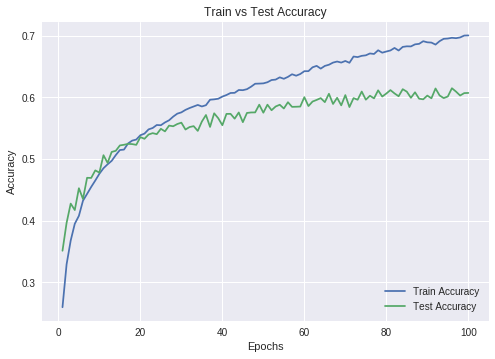

In [26]:
#CIFAR10
train_accs = [acc.cpu().item() for acc in train_accs]
test_accs = [acc.cpu().item() for acc in test_accs]
# print(train_accs)
# print(test_accs)
plt.style.use('seaborn')
plt.plot(range(1, 101), train_accs, label='Train Accuracy')
plt.plot(range(1, 101), test_accs, label='Test Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc='lower right')

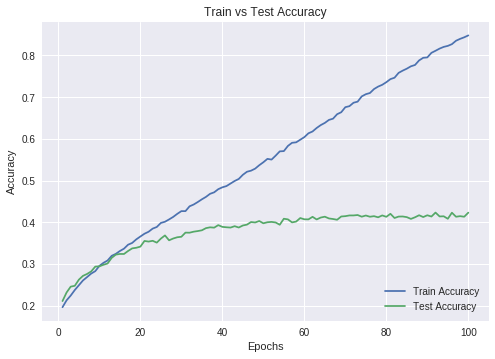

In [28]:
#CIFAR100
train_accs = [acc.cpu().item() for acc in train_accs]
test_accs = [acc.cpu().item() for acc in test_accs]
# print(train_accs)
# print(test_accs)
plt.style.use('seaborn')
plt.plot(range(1, 101), train_accs, label='Train Accuracy')
plt.plot(range(1, 101), test_accs, label='Test Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc='lower right')